## Amino acid composition weighted by copy number
#### Last updated 2022-08-07
This notebook computes the expected composition of a subset of ~50% of the IDRs in the human proteome compared with the same set of IDRs when weighted by their consitutive protein's copy number.

The basic question is, while we tend to calculate proteome-wide properties on each sequence, this implicitly assumes every protein is present at an equivalent copy number in reality, some proteins are expressed at much higher levels than others. This notebook uses per-protein copy-number information obtained by quantitative mass spectrometry (Hein et al. 2015). The copy number information from the supplementary table was excised and converted into a protein attributes file, which can be used to annotate the human proteom.

#### References
Hein, M. Y., Hubner, N. C., Poser, I., Cox, J., Nagaraj, N., Toyoda, Y., Gak, I. A., Weisswange, I., Mansfeld, J., Buchholz, F., Hyman, A. A., & Mann, M. (2015). A human interactome in three quantitative dimensions organized by stoichiometries and abundances. Cell, 163(3), 712–723.



In [98]:
### PLOTTING SETTINGS

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)



In [2]:
import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_protein_attributes, si_domains



In [3]:
human_prot = uniprot.uniprot_fasta_to_proteome('../shprd_data/human_proteome_validated.fasta')

si_protein_attributes.add_protein_attributes_from_file(human_prot,'../shprd_data/shprd_protein_attributes_concentrations.tsv')
si_domains.add_domains_from_file(human_prot,'../shprd_data/shprd_domains_idrs_metapredict_v2.tsv')


In [12]:
valid_aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
niave_aa_count = {}
copy_number_weighted_aa_count = {}

for aa in valid_aa:
    niave_aa_count[aa] = 0
    copy_number_weighted_aa_count[aa] = 0


In [13]:
for d in human_prot.domains:
    
    if 'copy_number' in d.protein.attributes:
        for aa in valid_aa:
            niave_aa_count[aa] = niave_aa_count[aa] + d.sequence.count(aa) 

In [22]:
t = np.sum(list(niave_aa_count.values()))

for aa in valid_aa:
    niave_aa_count[aa] = niave_aa_count[aa]/t

In [23]:
for d in human_prot.domains:
    if 'copy_number' in d.protein.attributes:
        for aa in valid_aa:
            copy_number_weighted_aa_count[aa] = copy_number_weighted_aa_count[aa] + d.sequence.count(aa)*int(d.protein.attribute('copy_number'))
            
            

In [24]:
t = np.sum(list(copy_number_weighted_aa_count.values()))

for aa in valid_aa:
    copy_number_weighted_aa_count[aa] = copy_number_weighted_aa_count[aa]/t

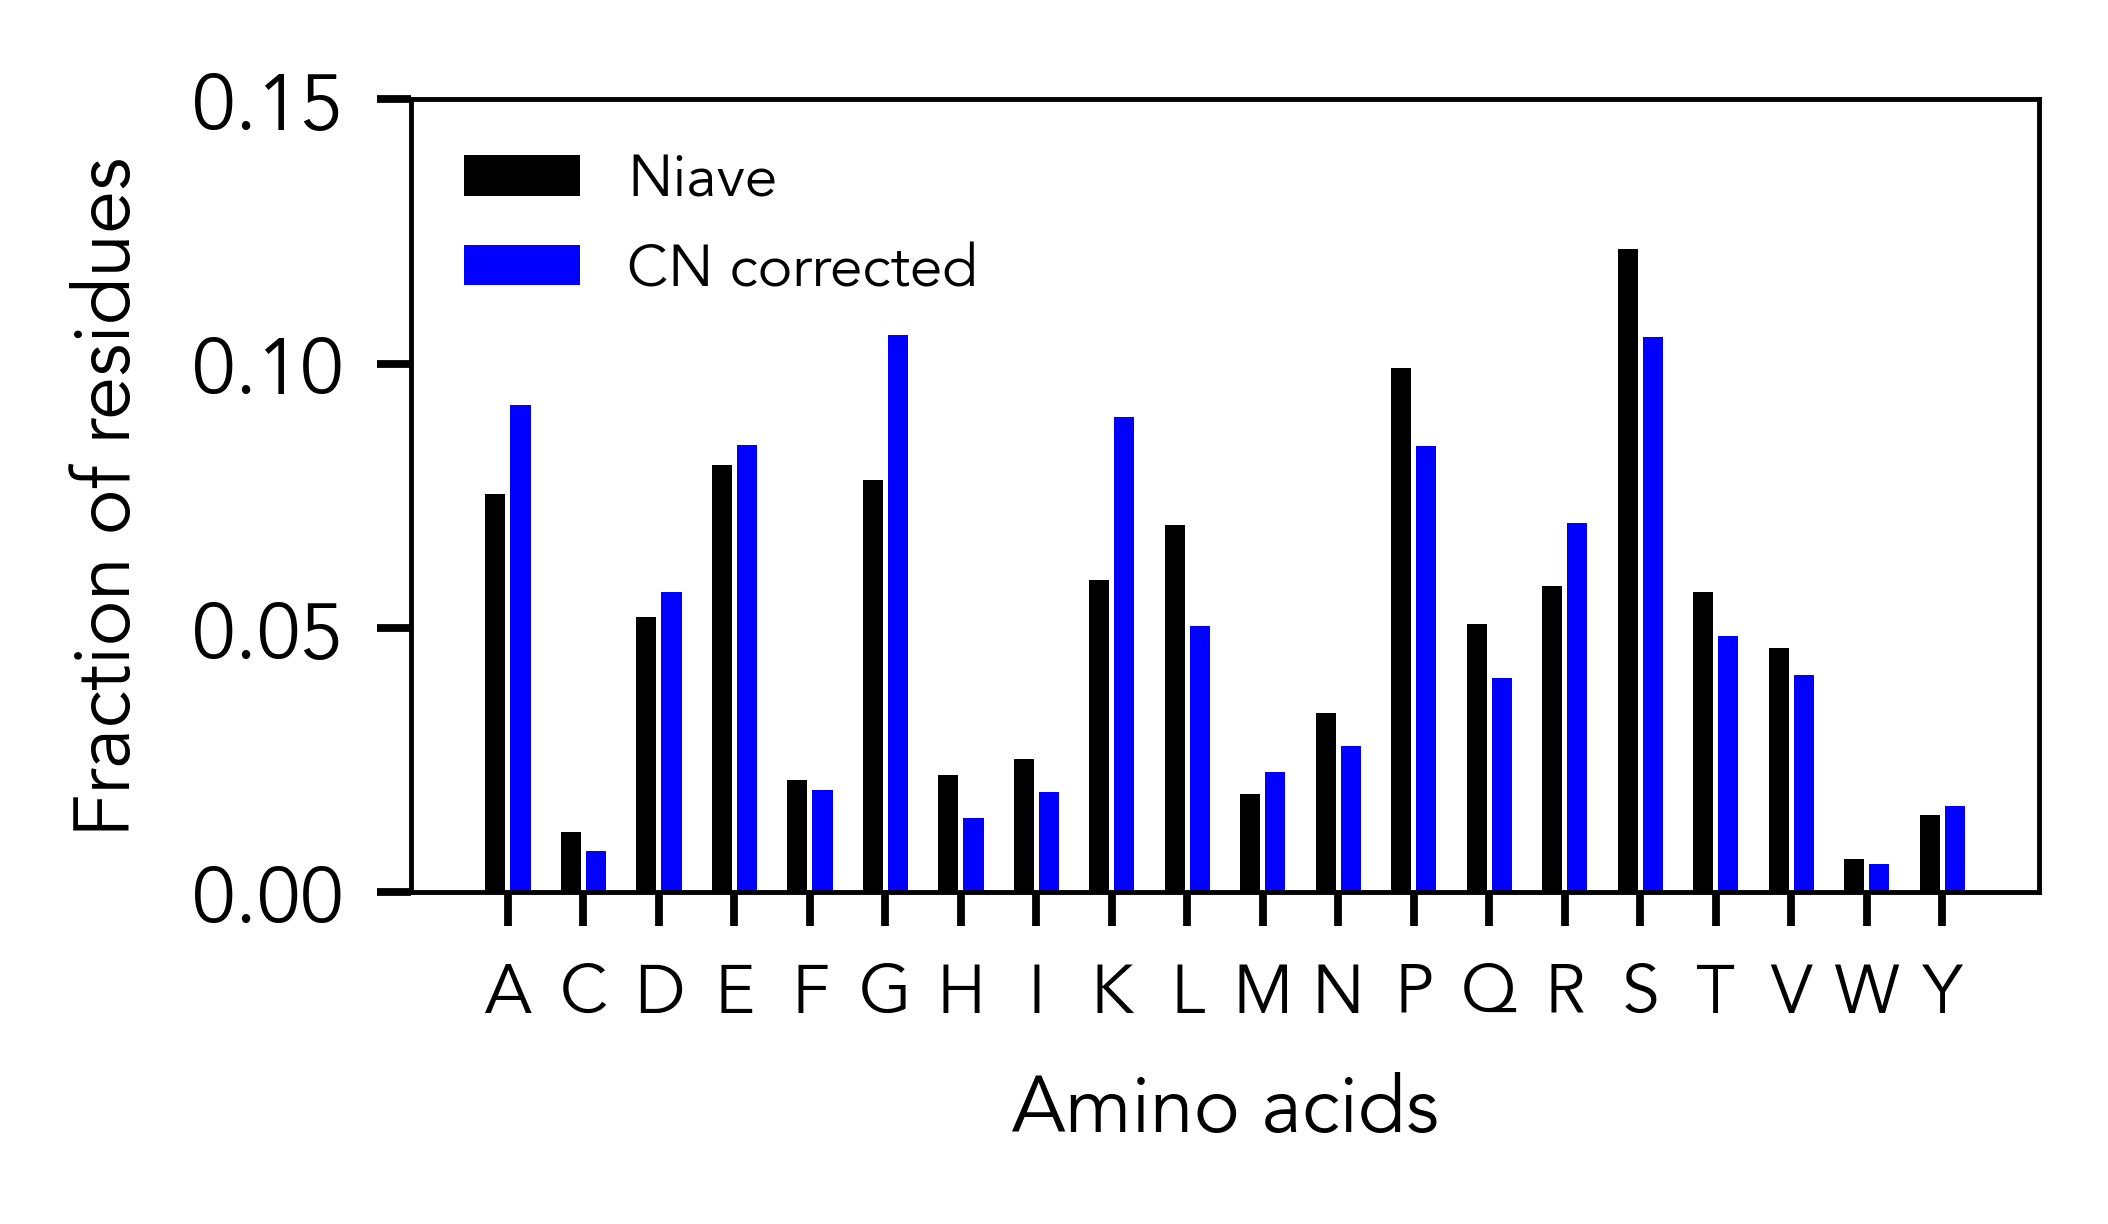

In [91]:
figure(None, (3,1.5), dpi=350)
stepsize=3
plt.bar(np.arange(1,0+(20*stepsize),stepsize),list(niave_aa_count.values()),color='k', label='Niave')
plt.bar(np.arange(2,1+(20*stepsize),stepsize),list(copy_number_weighted_aa_count.values()), color='blue', label='CN corrected')
plt.ylim(0,0.15)
#plt.plot(list(niave_aa_count.values()))
plt.xticks(np.arange(1.5,(20*stepsize)+0.5,stepsize),valid_aa, fontsize=7)
plt.ylabel('Fraction of residues', fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Amino acids', fontsize=8)
plt.legend(frameon=False, fontsize=6)

print('')

In [57]:
all_copy_numbers = [int(x) for x in [p.attribute('copy_number', safe=False) for p in human_prot] if x is not None]
all_copy_numbers.sort(reverse=True)


In [152]:
top_20 = all_copy_numbers[0:int(len(all_copy_numbers)*0.20)][-1]
bottom_20 = all_copy_numbers[int(len(all_copy_numbers)*0.80):][0]


In [153]:
top_20_fract_dis = []
bottom_20_fract_dis = []
middle_60_fract_dis = []
for p in human_prot:
    v = p.attribute('copy_number',safe=False)
    if v is not None:
        if int(v) < bottom_20:
            bottom_20_fract_dis.append(np.sum([len(d) for d in p.domains])/len(p))
            
        elif int(v) > top_20:
            top_20_fract_dis.append(np.sum([len(d) for d in p.domains])/len(p))
            
        else:
            middle_60_fract_dis.append(np.sum([len(d) for d in p.domains])/len(p))
            

In [154]:
import random
random.shuffle(middle_60_fract_dis)
subset = middle_60_fract_dis[0:len(top_20_fract_dis)]

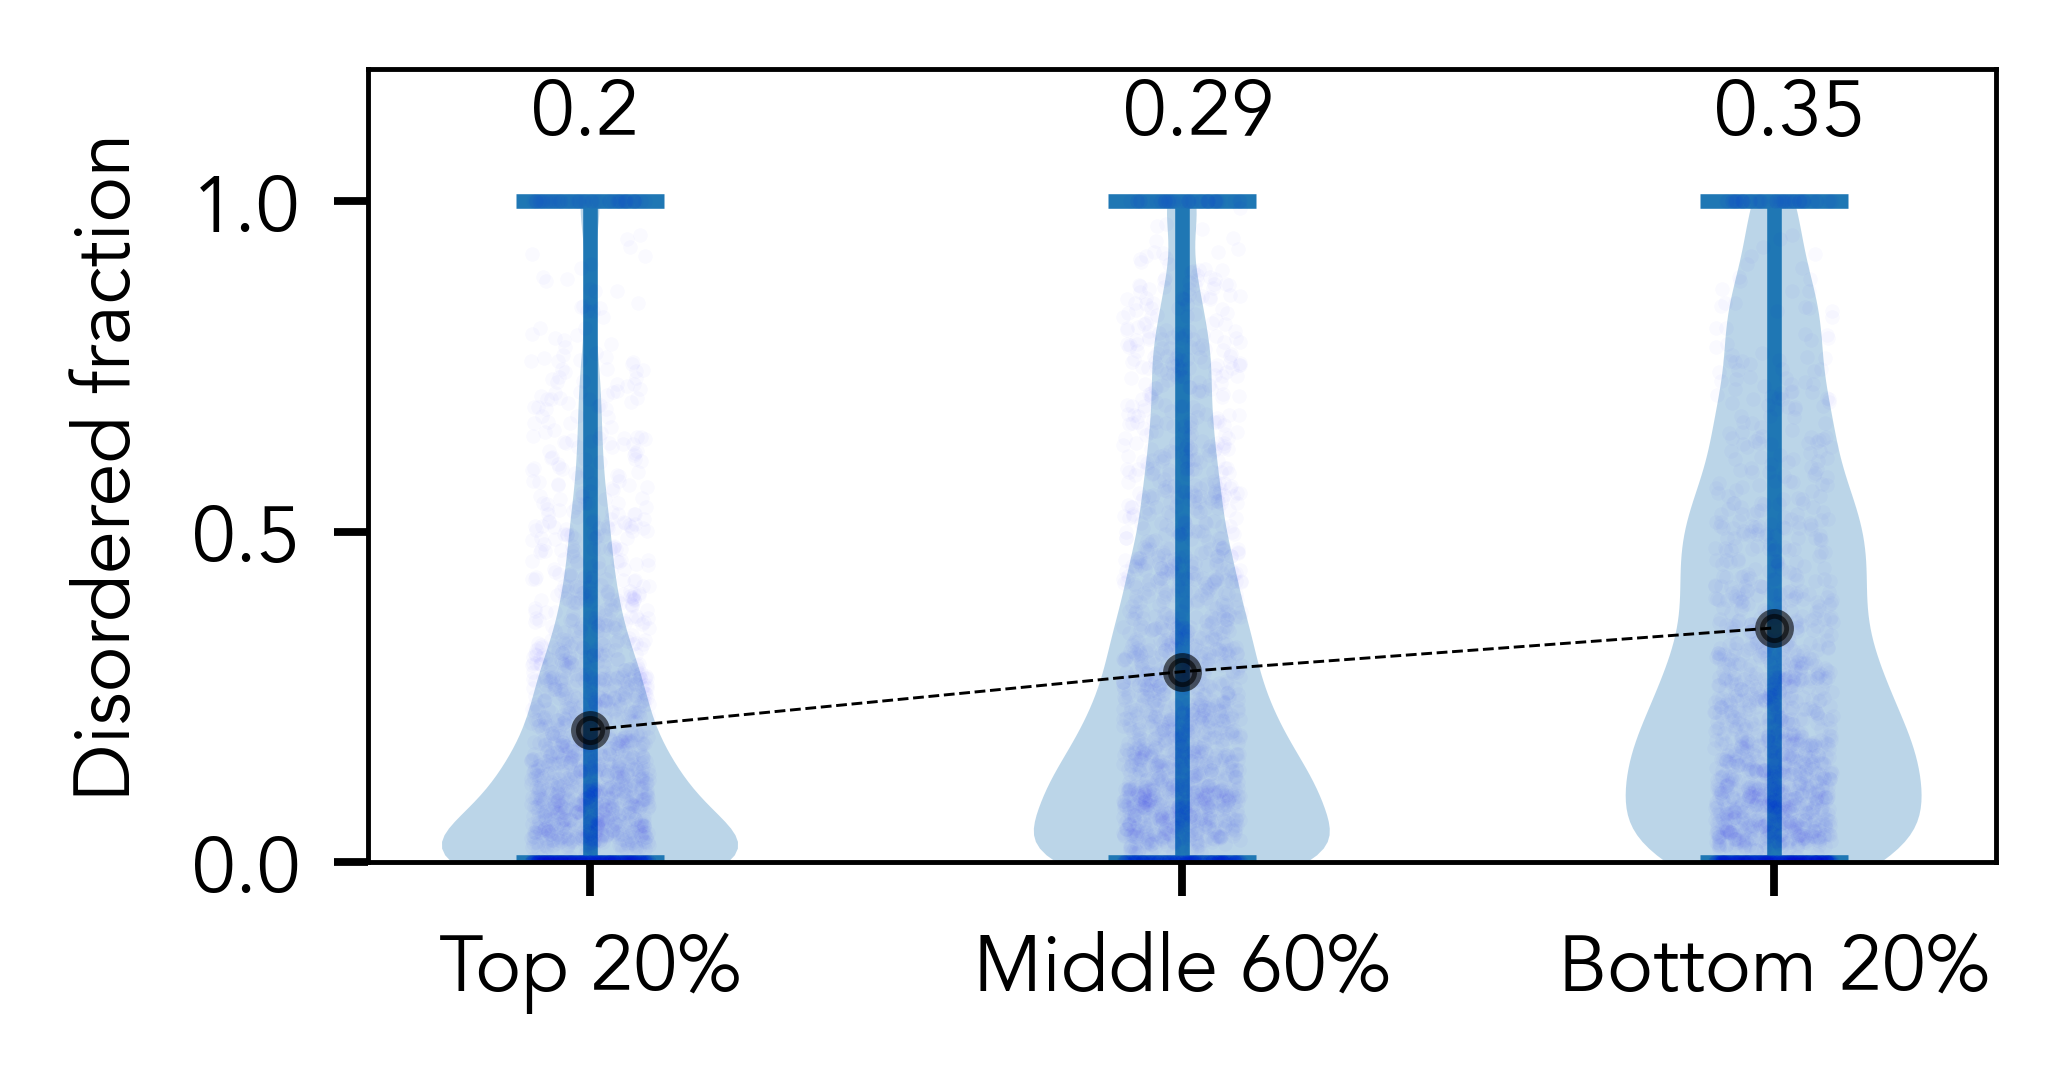

In [155]:
figure(None, (3,1.5), dpi=350)

plt.violinplot([top_20_fract_dis,middle_60_fract_dis,bottom_20_fract_dis])
for i in top_20_fract_dis:
    plt.plot(1+(np.random.rand()-0.5)*0.2, i, '.b', alpha=0.02, ms=3, mew=0)
    
for i in subset:
    plt.plot(2+(np.random.rand()-0.5)*0.2, i, '.b', alpha=0.02, ms=3, mew=0)    
    
for i in top_20_fract_dis:
    plt.plot(3+(np.random.rand()-0.5)*0.2, i, '.b', alpha=0.02, ms=3, mew=0)        
    
plt.xticks([1,2,3],['Top 20%', 'Middle 60%', 'Bottom 20%'], fontsize=8)    
plt.yticks(fontsize=8)    
plt.ylabel('Disordered fraction', fontsize=8)
plt.ylim([0,1.2])
plt.text(0.9,1.1, np.round(np.mean(top_20_fract_dis),2), fontsize=8)
plt.text(1.9,1.1, np.round(np.mean(middle_60_fract_dis),2), fontsize=8)
plt.text(2.9,1.1, np.round(np.mean(bottom_20_fract_dis),2), fontsize=8)
plt.plot(1, np.mean(top_20_fract_dis),'.k', alpha=0.6)
plt.plot(2, np.mean(middle_60_fract_dis),'.k', alpha=0.6)
plt.plot(3, np.mean(bottom_20_fract_dis),'.k', alpha=0.6)
plt.plot([1,2,3],[np.mean(top_20_fract_dis), np.mean(middle_60_fract_dis), np.mean(bottom_20_fract_dis)],'--k', linewidth=0.3)
                  
                  
                  
                  